In [9]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from criminisi import load_measurements
from utils import imshow, select_lines, draw_lines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Testing out how well this works

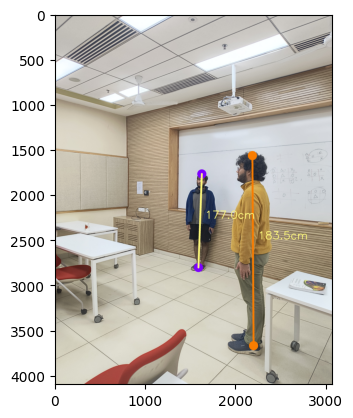

In [103]:
name = "kartripta12"

img = cv.imread(f"data/{name}.jpg")
depth = np.load(f"unidepth_out/depths.npz")[name]
known_lines, lengths = load_measurements(name)

drawn_heights = draw_lines(img, known_lines, lengths)

cv.imwrite(f"visuals/actual_heights_{name}.png", drawn_heights)
imshow(drawn_heights)

In [104]:
points = np.load("unidepth_out/points.npz")[name]
points.shape

(3, 3072, 4096)

In [105]:
lines = select_lines(img, 2).astype(np.uint64)

In [106]:
lines[0], lines[1]

(array([[2200, 3694],
        [2156, 1655]], dtype=uint64),
 array([[1601, 2785],
        [1624, 1810]], dtype=uint64))

In [107]:
meas_a = np.linalg.norm((points[:, lines[0, 0, 0], lines[0, 0, 1]]) - (points[:, lines[0, 1, 0], lines[0, 1, 1]])) * 100
meas_b = np.linalg.norm((points[:, lines[1, 0, 0], lines[1, 0, 1]]) - (points[:, lines[1, 1, 0], lines[1, 1, 1]])) * 100

meas_a, meas_b

(366.65682792663574, 166.29815101623535)

In [108]:
meas_a / lengths[0], meas_b / lengths[1]

(1.99812985246123, 0.9395375763629116)

In [109]:
measurements = [round(x, 2) for x in [meas_a, meas_b]]

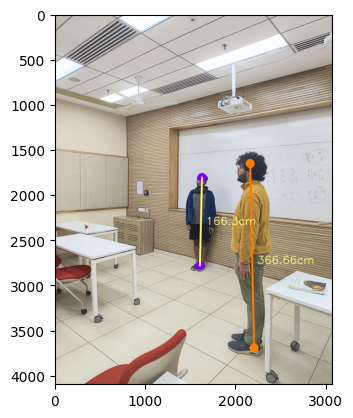

In [110]:
measured_heights = draw_lines(img, lines, measurements)
imshow(measured_heights)

In [111]:
cv.imwrite(f"visuals/measured_heights_{name}_ud.jpg", measured_heights)

True

### Point Cloud 

In [112]:
import open3d as o3d

H, W = img.shape[:-1]
K = np.load("r-calibration.npz")["K"]

intrinsics = o3d.camera.PinholeCameraIntrinsic(W, H, K[0, 0], K[1, 1], K[0, 2], K[1, 2])

In [113]:
color = o3d.geometry.Image(cv.cvtColor(img, cv.COLOR_BGR2RGB))
depth_o3d = o3d.geometry.Image(depth)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth_o3d, convert_rgb_to_intensity=False)

In [114]:
cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)

In [115]:
cloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
cloud

PointCloud with 12582912 points.

In [116]:
vis = o3d.visualization.Visualizer()

vis.create_window("the cloud", width = 1080, height = 1080)
vis.add_geometry(cloud)
vis.run()
vis.destroy_window()
